In [1]:
from itertools import accumulate
import numpy as np
import matplotlib.pyplot as plt
import yastn.tn.mps as mps

from hamiltonians import local_operators, Hamiltonian_dpt_position, Hamiltonian_dpt_momentum, Hamiltonian_dpt_mixed
from auxilliary import merge_sites, op1site
from hamiltonians import L, S, D, R

In [2]:
Hamiltonian = {"position": Hamiltonian_dpt_position,
               "mixed": Hamiltonian_dpt_mixed,
               "momentum": Hamiltonian_dpt_momentum,}

In [3]:
def init_occupations(mapping, NW, NS):
    """ Initial guess of occupations before DMRG. """
    occ = {}
    assert NW % 2 == 0, "Assume even NW for convinience"
    assert NS % 2 == 0, "Assume even NS"

    if mapping == "position":
        occ[D(1)] = 0
        for k in range(1, NS + 1):
            occ[S(k)] = 0.5
        for k in range(1, NW + 1):
            occ[L(k)] = 0.5
            occ[R(k)] = 0.5

    if mapping == "mixed":
        NW1 = NW + 1
        occ[D(1)] = 0
        for k in range(1, NS + 1):
            occ[S(k)] = 0.5
        for k in range(1, NW1):
            occ[L(k)] = np.heaviside(k - NW1 / 2, 0.5)
            occ[R(k)] = np.heaviside(k - NW1 / 2, 0.5)

    if mapping == "momentum":
        NW1 = NW + NS // 2 + 1
        occ[D(1)] = 0
        for k in range(1, NW1):
            occ[L(k)] = np.heaviside(k - NW1 / 2, 0.5)
            occ[R(k)] = np.heaviside(k - NW1 / 2, 0.5)

    assert sum(occ.values()) == NW + NS // 2, "We should have half-filling."
    return occ

In [4]:
def SDS_sites(NS):
    sites =  [S(k) for k in range(1, NS // 2 + 1)]
    sites += [D(1)]
    sites += [S(k) for k in range(NS // 2 + 1, NS + 1)]
    return sites

def S_sites(NS):
    return [S(k) for k in range(1, NS + 1)]

def order_sites(mapping, order, NW, NS=4):
    """ predefined ordering of sites """
    if mapping == 'position':
        if order == 'DLSR':
            sites =  [D(1)]
            sites += [L(k) for k in range(NW, 0, -1)]  # 'L1' is for L mode at the junction
            sites += S_sites(NS)  # 'S1' connected to L1
            sites += [R(k) for k in range(1, NW + 1)]  # 'R1' is for R mode at the junction
        elif order == 'LSDSR':
            sites =  [L(k) for k in range(NW, 0, -1)]  # 'L1' is for L mode at the junction
            sites += SDS_sites(NS)
            sites += [R(k) for k in range(1, NW + 1)]  # 'R1' is for R mode at the junction
        else:
            raise ValueError("For mapping='position' select order from 'DLSR', LSDSR'.")
        return sites

    if mapping == 'mixed':
        if order in ['DLSR', 'LSDSR']:
            return order_sites('position', order, NW, NS)
        if order in ['LRSDSLR', 'DLRSLR']:
            sites = []
            for k in range(1, NW + 1):
                sites.append(L(k))
                sites.append(R(k))
            if order == 'LRSDSLR':
                return sites[:NW] + SDS_sites(NS) + sites[NW:]
            if order == 'DLRSLR':
                return [D(1)] + sites[:NW] + S_sites(NS) + sites[NW:]
        else:
            raise ValueError("For 'mixed' select order from 'DLSR', LSDSR', 'LRSDSLR', 'DLRSLR'.")

    if mapping == 'momentum':
        if order == 'LDR':
            return order_sites('position', "LSDSR", NW + NS // 2, NS=0)
        if order == 'DLR':
            return order_sites('position', "DLSR", NW + NS // 2, NS=0)
        if order == 'LRDLR':
            return order_sites('mixed', "LRSDSLR", NW + NS // 2, NS=0)
        if order == 'DLRLR':
            return order_sites('mixed', "DLRSLR", NW + NS // 2, NS=0)
        raise ValueError("For 'momentum' select order from 'DLR', LDR', 'LRDLR', 'DLRLR'.")

    raise ValueError("mapping should be 'mixed', 'momentum', or 'position'.")


In [5]:
# test order_sites
mappings = [('position', 'DLSR'),
            ('position', 'LSDSR'),
            ('mixed', 'DLSR'),
            ('mixed', 'LSDSR'),
            ('mixed', 'LRSDSLR'),
            ('mixed', 'DLRSLR'),
            ('momentum', 'DLR'),
            ('momentum', 'LDR'),
            ('momentum', 'LRDLR'),
            ('momentum', 'DLRLR'),]

for mapping, order in mappings:
    print(order_sites(mapping, order, NW=4, NS=4), mapping, order)


['D1', 'L4', 'L3', 'L2', 'L1', 'S1', 'S2', 'S3', 'S4', 'R1', 'R2', 'R3', 'R4'] position DLSR
['L4', 'L3', 'L2', 'L1', 'S1', 'S2', 'D1', 'S3', 'S4', 'R1', 'R2', 'R3', 'R4'] position LSDSR
['D1', 'L4', 'L3', 'L2', 'L1', 'S1', 'S2', 'S3', 'S4', 'R1', 'R2', 'R3', 'R4'] mixed DLSR
['L4', 'L3', 'L2', 'L1', 'S1', 'S2', 'D1', 'S3', 'S4', 'R1', 'R2', 'R3', 'R4'] mixed LSDSR
['L1', 'R1', 'L2', 'R2', 'S1', 'S2', 'D1', 'S3', 'S4', 'L3', 'R3', 'L4', 'R4'] mixed LRSDSLR
['D1', 'L1', 'R1', 'L2', 'R2', 'S1', 'S2', 'S3', 'S4', 'L3', 'R3', 'L4', 'R4'] mixed DLRSLR
['D1', 'L6', 'L5', 'L4', 'L3', 'L2', 'L1', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6'] momentum DLR
['L6', 'L5', 'L4', 'L3', 'L2', 'L1', 'D1', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6'] momentum LDR
['L1', 'R1', 'L2', 'R2', 'L3', 'R3', 'D1', 'L4', 'R4', 'L5', 'R5', 'L6', 'R6'] momentum LRDLR
['D1', 'L1', 'R1', 'L2', 'R2', 'L3', 'R3', 'L4', 'R4', 'L5', 'R5', 'L6', 'R6'] momentum DLRLR


In [33]:
def initial_state(NW, NS, U, muL, muR, vS0, alpha, mapping, order, merge, sym, D_total, muDs=[0, 10000]):

    sites = order_sites(mapping, order, NW, NS)
    init_occ = init_occupations(mapping, NW, NS)

    if sym == 'U1':
        n_profile = [NW + NS // 2 - x for x in accumulate([init_occ[site] for site in sites], initial=0)]
    elif sym == 'Z2':
        n_profile = 0
    else:
        raise ValueError("Only sym = 'U1' or 'Z2' suported.")

    H0, s2i, i2s = Hamiltonian[mapping](NW, NS, muL, muR, muDs, vS0, U * (2 * alpha - 1), sym=sym, order=sites)
    qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)

    psi = mps.random_mps(H0, n=n_profile, D_total=D_total, sigma=2)

    H0 = merge_sites(H0, s2i, merge)
    psi = merge_sites(psi, s2i, merge)
    psi.canonize_(to='last').canonize_(to='first')

    opts_svd = {"D_total": D_total}
    print("Running 2-site DMRG ... ")
    info = mps.dmrg_(psi, H0, method='2site', opts_svd=opts_svd, max_sweeps=32, Schmidt_tol=1e-10)
    print(info)
    print("Running 1-site DMRG ... ")
    info = mps.dmrg_(psi, H0, method='1site', max_sweeps=256, Schmidt_tol=1e-10)
    print(info)

    O = (np.sqrt(alpha) * dn1 + np.sqrt(1 - alpha) * m12)
    O = op1site(O, 'D1', s2i, qI, dI)
    O = merge_sites(O, s2i, merge)

    psi = O @ psi
    psi.canonize_(to='last')
    psi.canonize_(to='first')

    On1 = merge_sites(op1site(dn1, 'D1', s2i, qI, dI), s2i, merge)
    On2 = merge_sites(op1site(dn2, 'D1', s2i, qI, dI), s2i, merge)

    print("Done. n1 = ", mps.vdot(psi, On1, psi), "n2 = ", mps.vdot(psi, On2, psi))
    return psi, info.energy

In [7]:
def run_evolution(psi, NW, NS, U, muL, muR, vS0, vS1, mapping, order, merge, sym, D_total, tswitch, tfin, dt, muDs=[0, 0], verbose=0):

    sites = order_sites(mapping, order, NW, NS=4)

    H1, s2i, i2s = Hamiltonian[mapping](NW, NS, muL, muR, muDs, vS0, U, sym=sym, order=sites)
    H2, s2i, i2s = Hamiltonian[mapping](NW, NS, muL, muR, muDs, vS1, U, sym=sym, order=sites)
    qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)

    On1 = merge_sites(op1site(dn1, 'D1', s2i, qI, dI), s2i, merge)
    On2 = merge_sites(op1site(dn2, 'D1', s2i, qI, dI), s2i, merge)
    Om12 = merge_sites(op1site(m12, 'D1', s2i, qI, dI), s2i, merge)
    Ons = {ss: merge_sites(op1site(qn, ss, s2i, qI, dI), s2i, merge) for ss in s2i if ss != 'D1'}

    H1 = merge_sites(H1, s2i, merge)
    H2 = merge_sites(H2, s2i, merge)

    ts = []
    traces = {'n1': [], 'n2': [], 'm12': [], 'max_ent': []}
    for site in sites:
        if 'S' in site:
            traces[site] = []

    opts_svd = {"D_total": D_total, 'tol': 1e-6}
    print("Running time evolution ... ")
    for t0, t1, H in [(0, tswitch, H1), (tswitch, tfin, H2)]:
        times = np.linspace(t0, t1, int((t1 - t0) * 4) + 1)
        for step in mps.tdvp_(psi, H, times, method='12site', dt=dt, opts_svd=opts_svd, yield_initial=True, subtract_E=True):
            if verbose:
                print(step)
            ts.append(step.tf)
            traces['n1'].append(mps.vdot(psi, On1, psi).real)
            traces['n2'].append(mps.vdot(psi, On2, psi).real)
            traces['m12'].append(mps.vdot(psi, Om12, psi).real)
            for site in sites:
                if 'S' in site:
                    traces[site].append(mps.vdot(psi, Ons[site], psi).real)

            ent = psi.get_entropy()
            traces['max_ent'].append(max(ent))
    print("Done.")
    return psi, ts, traces

In [8]:
def plot_data(psi, ts, traces, mapping, order, merge, sym):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(8, 6)
    axs[0, 0].plot(psi.get_entropy(), '-+')
    axs[0, 0].set_xlabel("position in MPS")
    axs[0, 0].set_ylabel("entropy")

    axs[0, 1].plot(ts, traces['max_ent'], '-')
    axs[0, 1].set_xlabel("time")
    axs[0, 1].set_ylabel("max entropy")

    axs[1, 0].plot(ts, traces['n1'], '-')
    axs[1, 0].set_xlabel("time")
    axs[1, 0].set_ylabel("occupation n1")

    for k in ['n1', 'n2', 'm12', 'S1', 'S2', 'S3', 'S4']:
        if k in traces and traces[k]:
            axs[1, 1].plot(ts, traces[k], label=k)
    axs[1, 1].legend()
    axs[1, 1].set_xlabel("time")

    fig.suptitle(f"{mapping=} {order=} {merge=} {sym=}")
    fig.tight_layout()


In [9]:
NW = 8
NS = 4
U = 3.05
muL = 0
muR = 0
alpha= 0.7
vS0 = 0
vS1 = 0.25

dt = 0.126
tswitch, tfin = 2, 6
D_total = 32

In [10]:
# mapping = 'position'
# order = 'DLSR'
# merge = True
# sym = 'U1'

# psi, energy = initial_state(NW, NS, U, muL, muR, vS0, alpha, mapping, order, merge, sym, D_total=32)
# psi, ts, traces = run_evolution(psi, NW, NS, U, muL, muR, vS0, vS1, mapping, order, merge, sym, D_total, tswitch, tfin, dt, verbose=0)

In [11]:
# mapping, order, merge, sym = ('mixed', 'LRSDSLR', False, 'U1')
# psi, energy = initial_state(NW, NS, U, muL, muR, vS0, alpha, mapping, order, merge, sym, D_total=32)

In [57]:
eng0 = {}
psi0 = {}
out = {}
for mapping, order in mappings:
    for merge in [True, False]:
        for sym in ['U1', 'Z2']:
            print("-----------------------")
            print(mapping, order, merge, sym)
            psi, eng0[mapping, order, merge, sym] = initial_state(NW, NS, U, muL, muR, vS0, alpha, mapping, order, merge, sym, D_total)
            psi0[mapping, order, merge, sym] = psi
            # out[mapping, order, merge, sym] = run_evolution(psi, NW, NS, U, muL, muR, vS0, vS1, mapping, order, merge, sym, D_total, tswitch, tfin, dt, verbose=0)

-----------------------
position DLSR True U1
Running 2-site DMRG ... 
DMRG_out(sweeps=21, method='2site', energy=-12.476376587099216, denergy=1.7763568394002505e-14, max_dSchmidt=8.609706246735309e-11, max_discarded_weight=1.1454768392708616e-05)
Running 1-site DMRG ... 
DMRG_out(sweeps=5, method='1site', energy=-12.476376587124824, denergy=2.842170943040401e-14, max_dSchmidt=1.1382147587322471e-11, max_discarded_weight=None)
Done. n1 =  0.6999999999999997 n2 =  0.2999999999999999
-----------------------
position DLSR True Z2
Running 2-site DMRG ... 
DMRG_out(sweeps=16, method='2site', energy=-12.476376587096874, denergy=1.5987211554602254e-14, max_dSchmidt=9.587322333823258e-11, max_discarded_weight=1.140370610722514e-05)
Running 1-site DMRG ... 
DMRG_out(sweeps=5, method='1site', energy=-12.47637658712189, denergy=3.552713678800501e-15, max_dSchmidt=1.1737518025777193e-11, max_discarded_weight=None)
Done. n1 =  0.6999999999999995 n2 =  0.2999999999999998
-----------------------
posi

In [34]:
# fixing some initial energy by hand ...
mapping, order, merge, sym = ('mixed', 'LRSDSLR', False, 'U1')
print(eng0[mapping, order, merge, sym])
psi, eng0[mapping, order, merge, sym] = initial_state(NW, NS, U, muL, muR, vS0, alpha, mapping, order, merge, sym, D_total)
psi0[mapping, order, merge, sym] = psi
out[mapping, order, merge, sym] = run_evolution(psi, NW, NS, U, muL, muR, vS0, vS1, mapping, order, merge, sym, D_total, tswitch, tfin, dt, verbose=0)

-12.475524538060188
Running 2-site DMRG ... 
DMRG_out(sweeps=24, method='2site', energy=-12.47632270619421, denergy=5.861977570020827e-14, max_dSchmidt=9.772996312391718e-11, max_discarded_weight=1.7574990141051155e-05)
Running 1-site DMRG ... 
DMRG_out(sweeps=10, method='1site', energy=-12.47632270623055, denergy=2.3092638912203256e-14, max_dSchmidt=7.308224844382173e-11, max_discarded_weight=None)
Done. n1 =  0.7 n2 =  0.30000000000000043
Running time evolution ... 
Done.


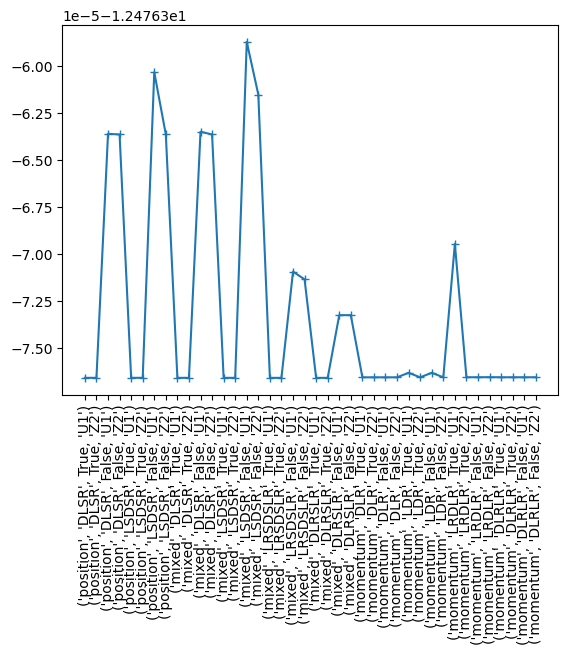

-12.476376587124824 ('position', 'DLSR', True, 'U1')
-12.47637658712189 ('position', 'DLSR', True, 'Z2')
-12.476363595435174 ('position', 'DLSR', False, 'U1')
-12.476363628466723 ('position', 'DLSR', False, 'Z2')
-12.47637658711829 ('position', 'LSDSR', True, 'U1')
-12.47637658711035 ('position', 'LSDSR', True, 'Z2')
-12.47636031221683 ('position', 'LSDSR', False, 'U1')
-12.476363628172383 ('position', 'LSDSR', False, 'Z2')
-12.476376587879365 ('mixed', 'DLSR', True, 'U1')
-12.476376588133268 ('mixed', 'DLSR', True, 'Z2')
-12.476363483603699 ('mixed', 'DLSR', False, 'U1')
-12.476363627544375 ('mixed', 'DLSR', False, 'Z2')
-12.476376588142495 ('mixed', 'LSDSR', True, 'U1')
-12.47637658814715 ('mixed', 'LSDSR', True, 'Z2')
-12.476358695911607 ('mixed', 'LSDSR', False, 'U1')
-12.476361503250352 ('mixed', 'LSDSR', False, 'Z2')
-12.476376588774054 ('mixed', 'LRSDSLR', True, 'U1')
-12.476376588768476 ('mixed', 'LRSDSLR', True, 'Z2')
-12.476370930636266 ('mixed', 'LRSDSLR', False, 'U1')
-12.4

In [58]:
plt.plot(list(str(x) for x in eng0.keys()), list(eng0.values()), '-+');
plt.xticks(rotation=90);
plt.show()
for k, v in eng0.items():
    print(v, k)

In [42]:
plt.cm.tab10(0)

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

(0.65, 0.71)

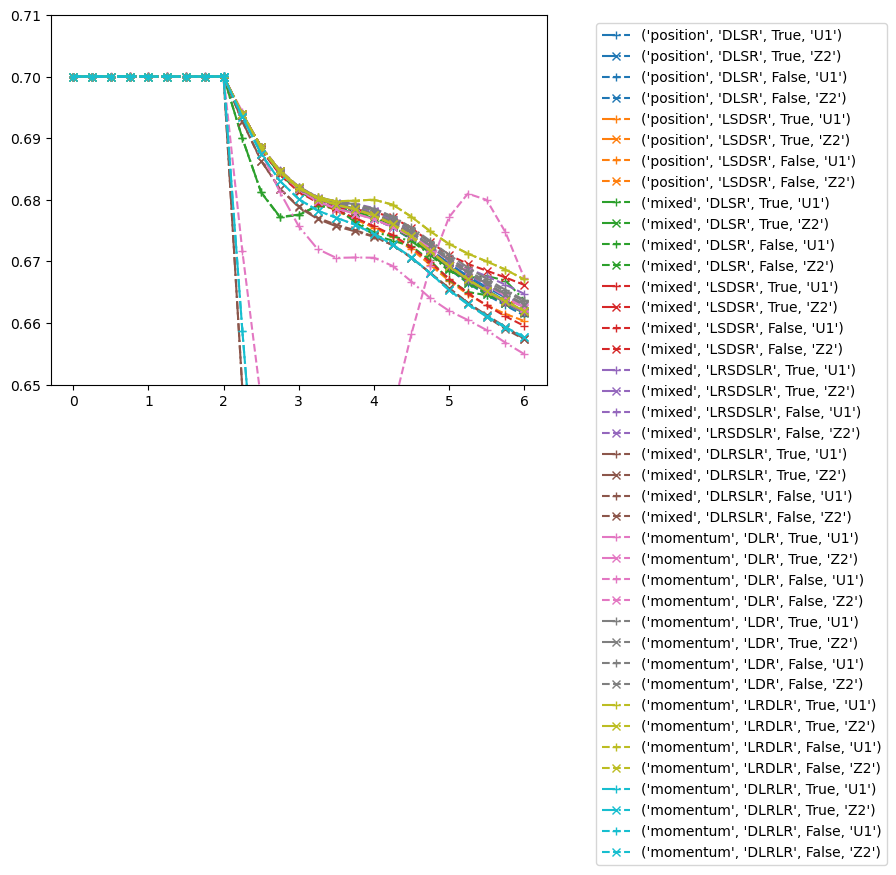

In [56]:
colors = dict(zip(mappings, map(plt.cm.tab10, range(10))))
lines = {True: '-.', False: '--'}
symbols = {"U1": '+', "Z2": "x"}

for k, v in out.items():
    mapping, order, merge, sym = k
    plt.plot(v[1], v[2]['n1'], color=colors[mapping, order], marker=symbols[sym], linestyle=lines[merge], label=k)
plt.legend(loc=(1.1, -1.3))
plt.ylim([0.65, 0.71])


/var/folders/37/qcskmxyd1837qz40mxtgbbg40000gn/T/ipykernel_23572/2195378185.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2)


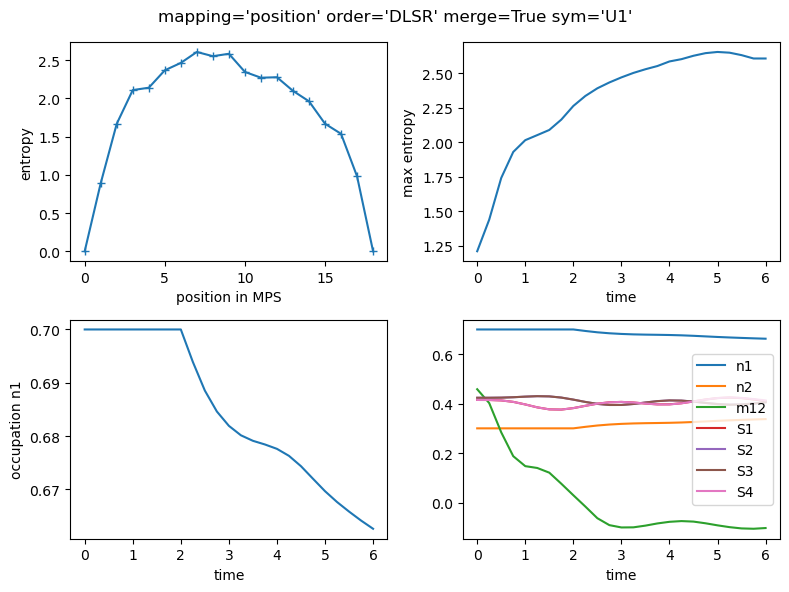

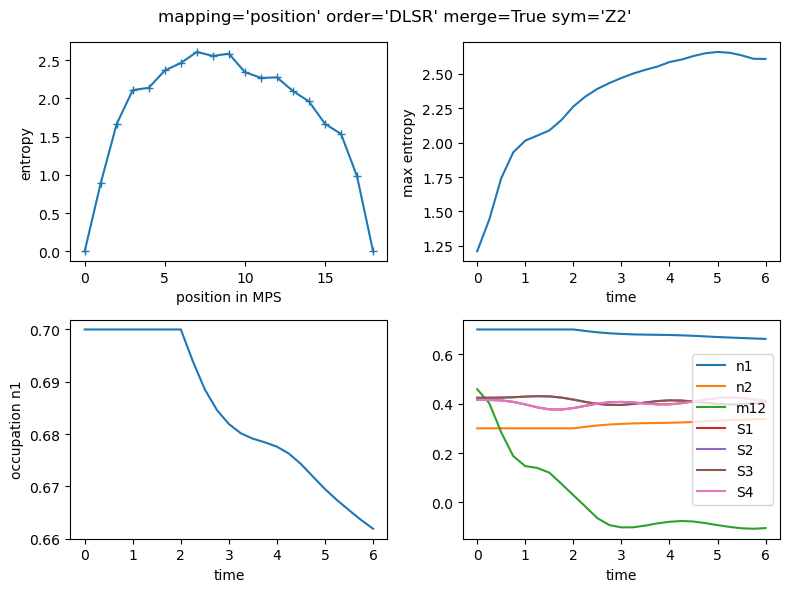

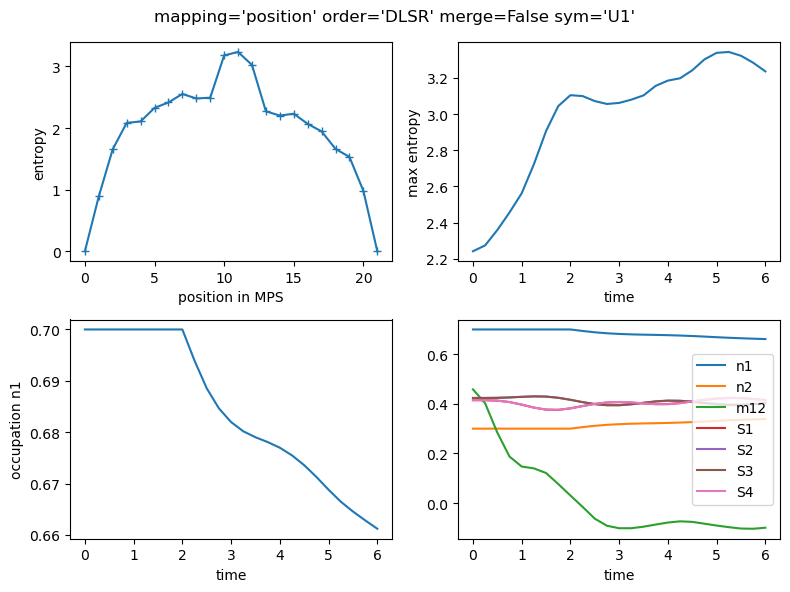

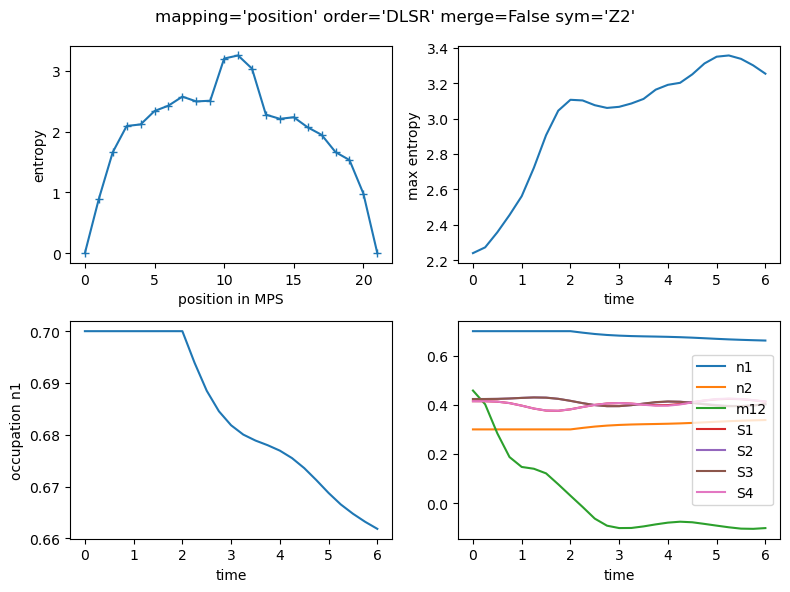

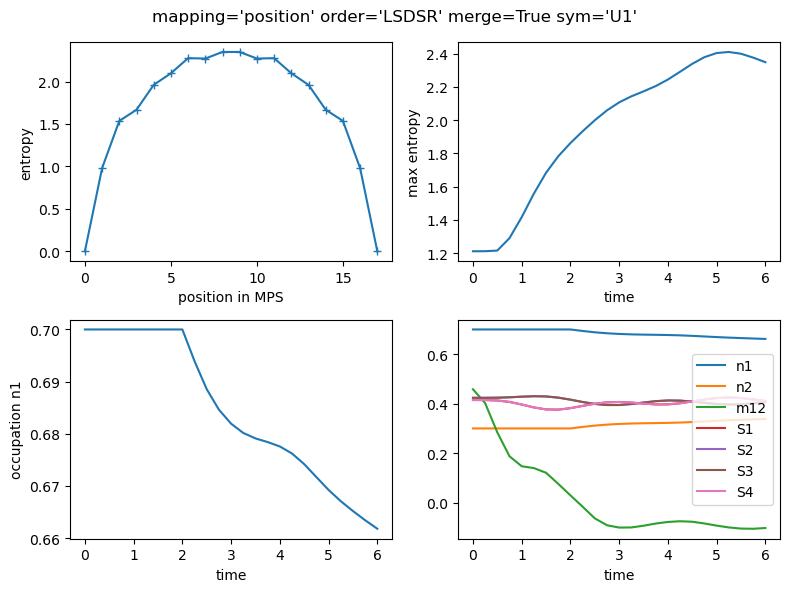

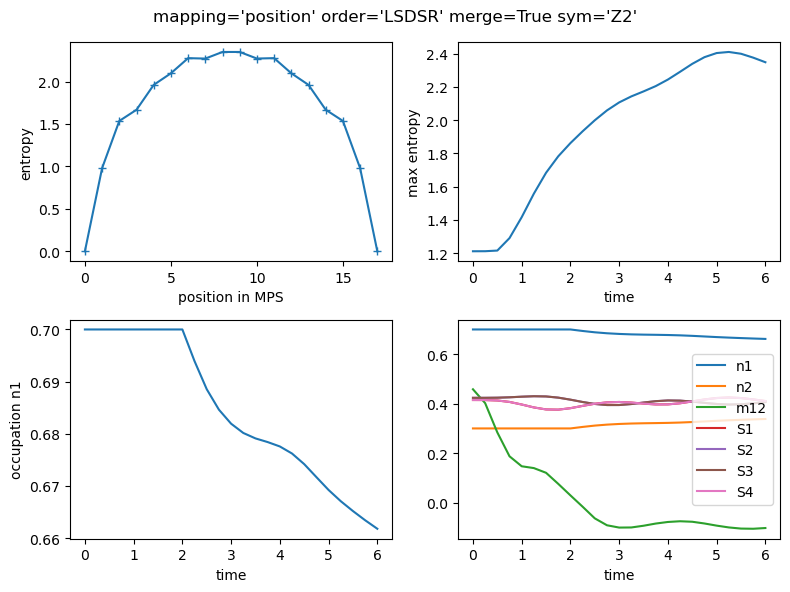

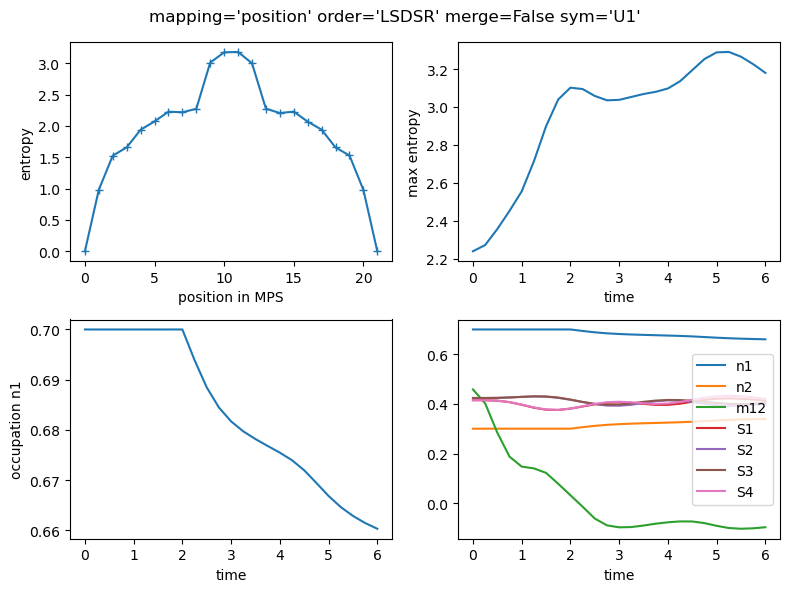

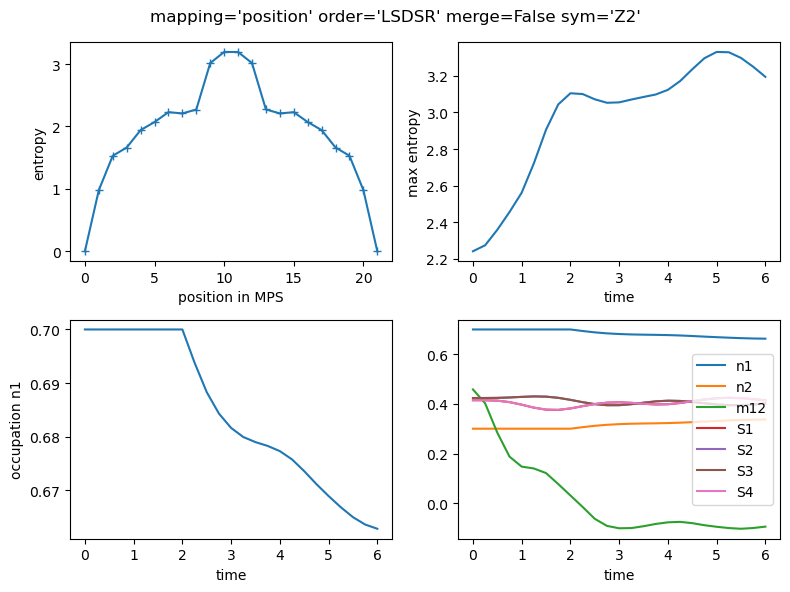

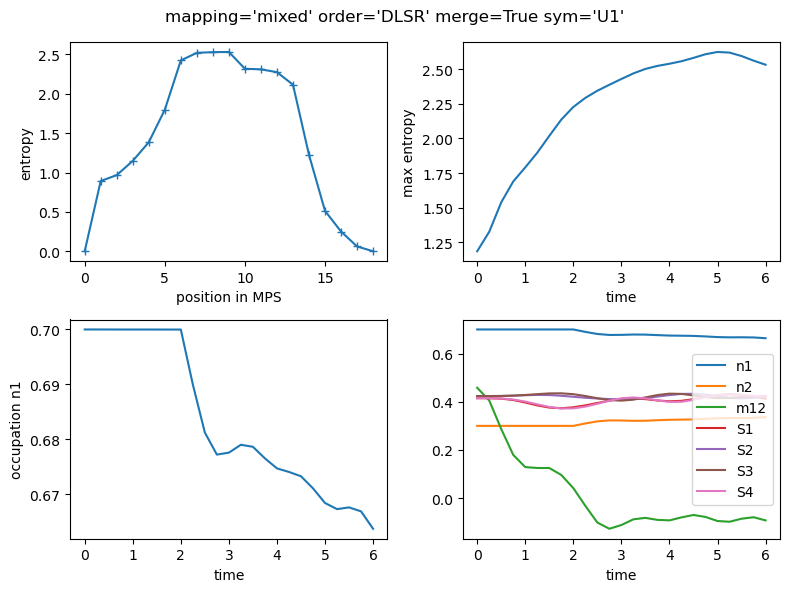

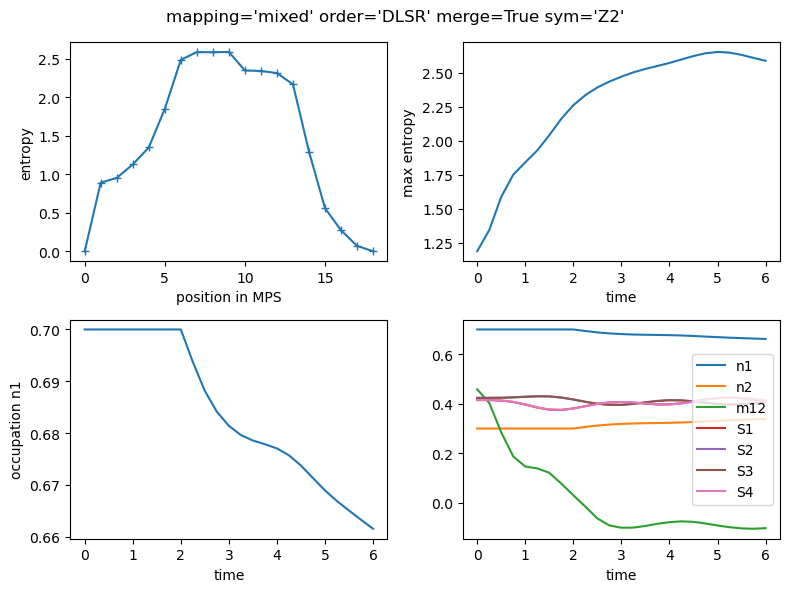

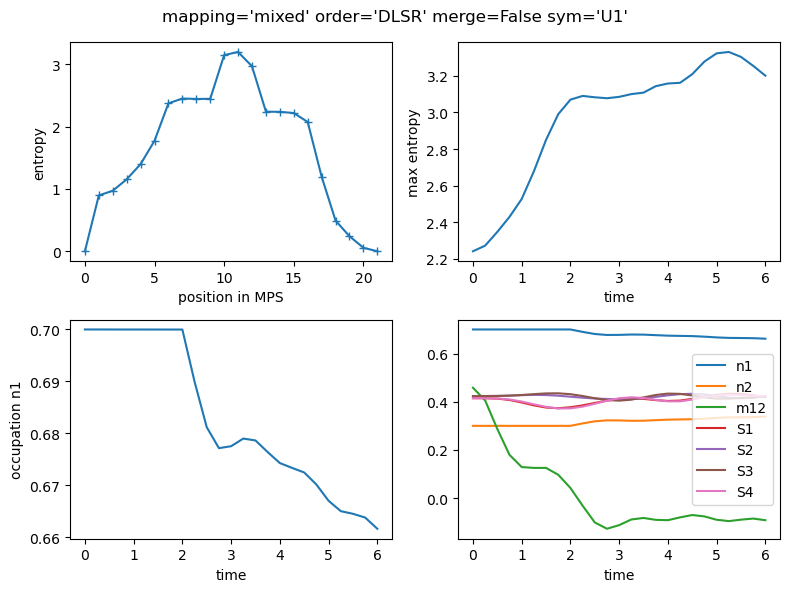

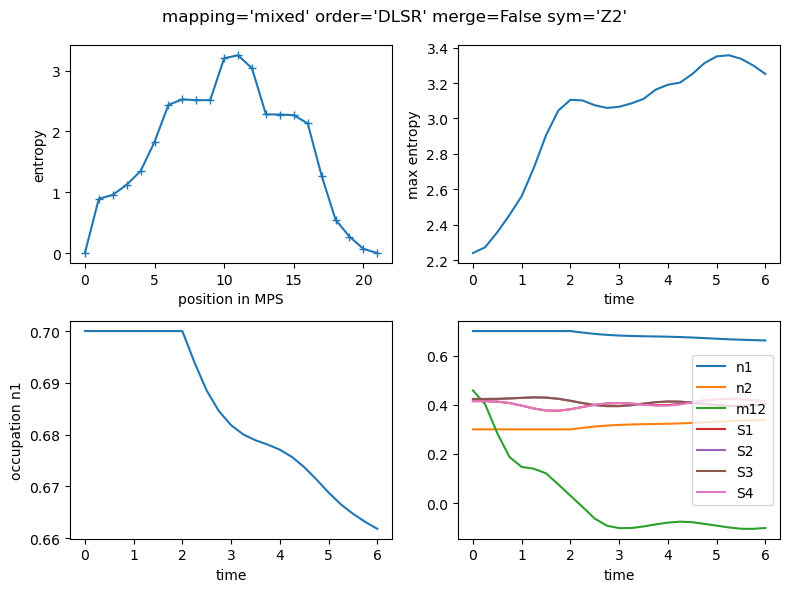

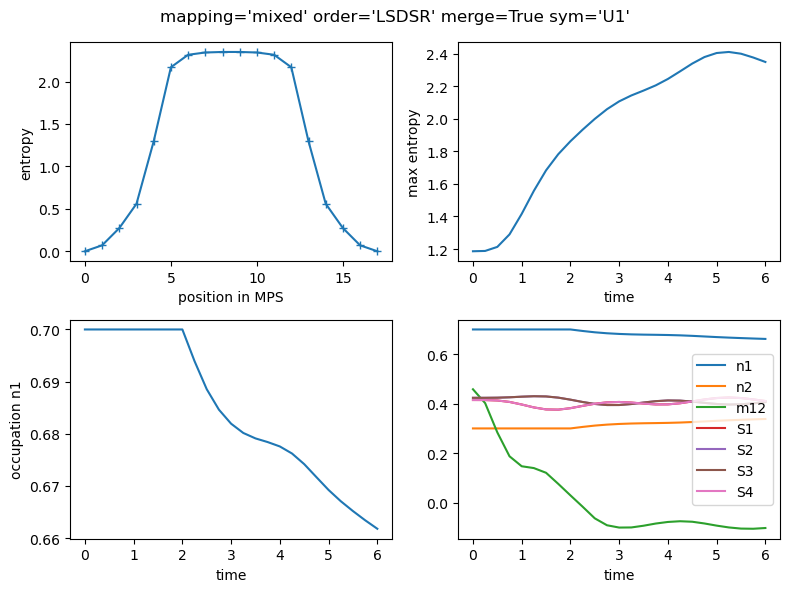

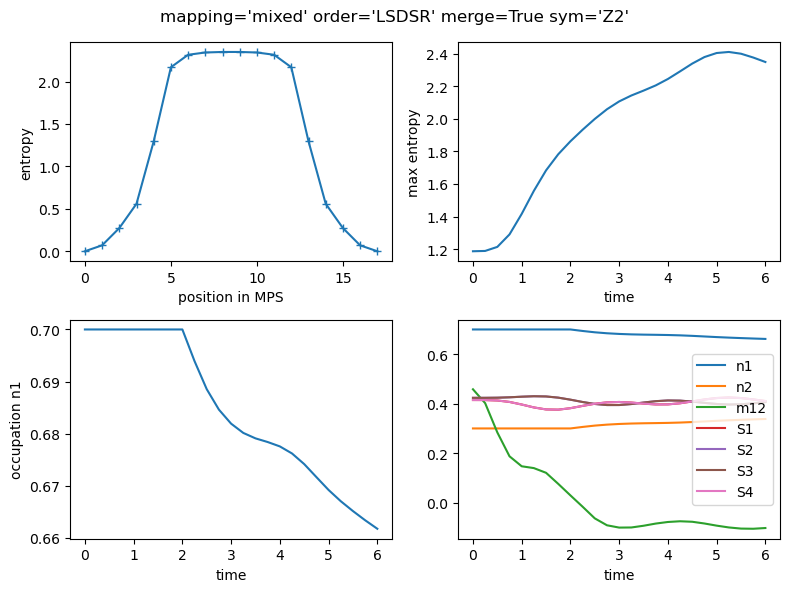

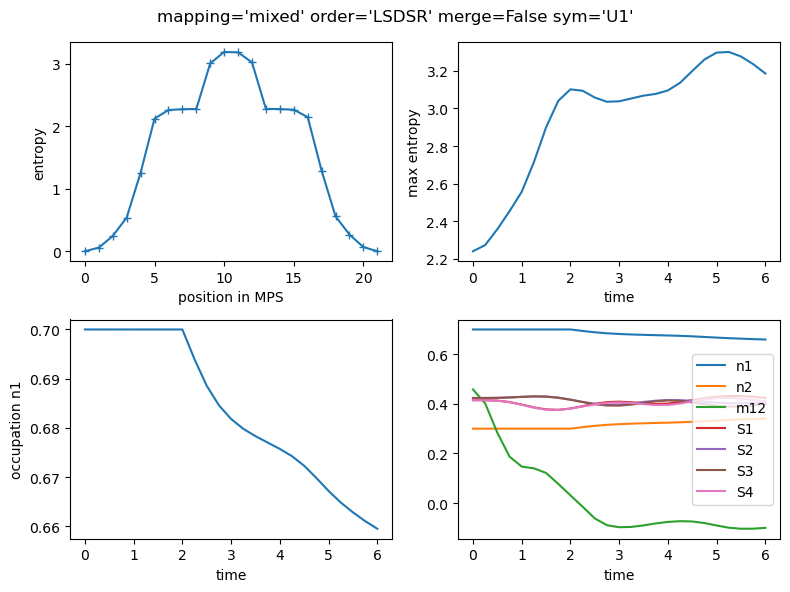

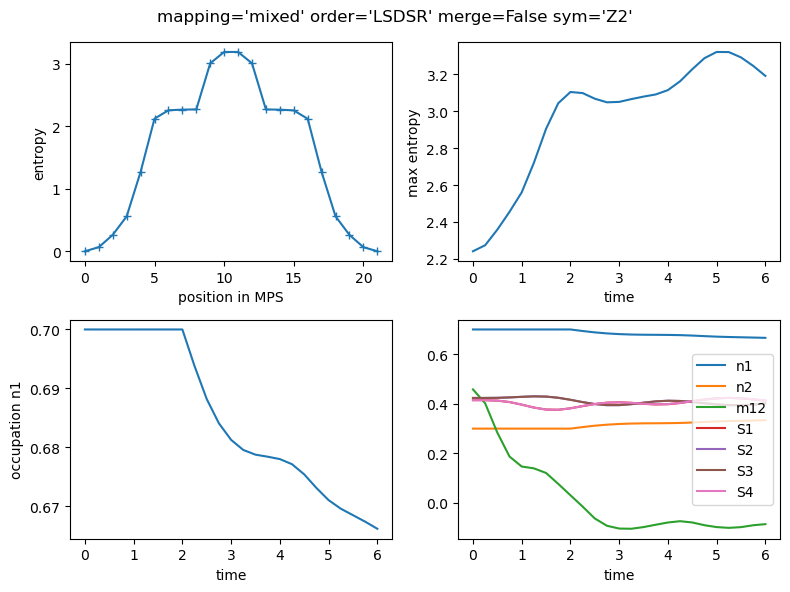

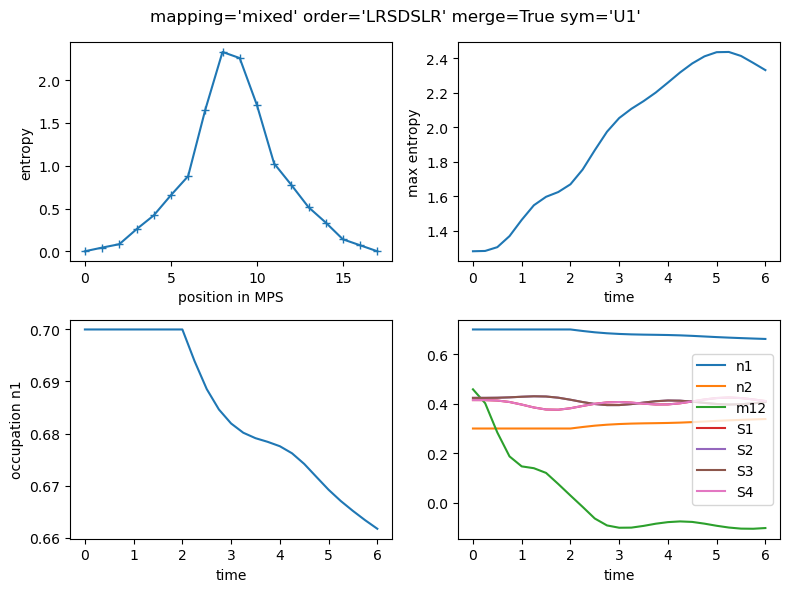

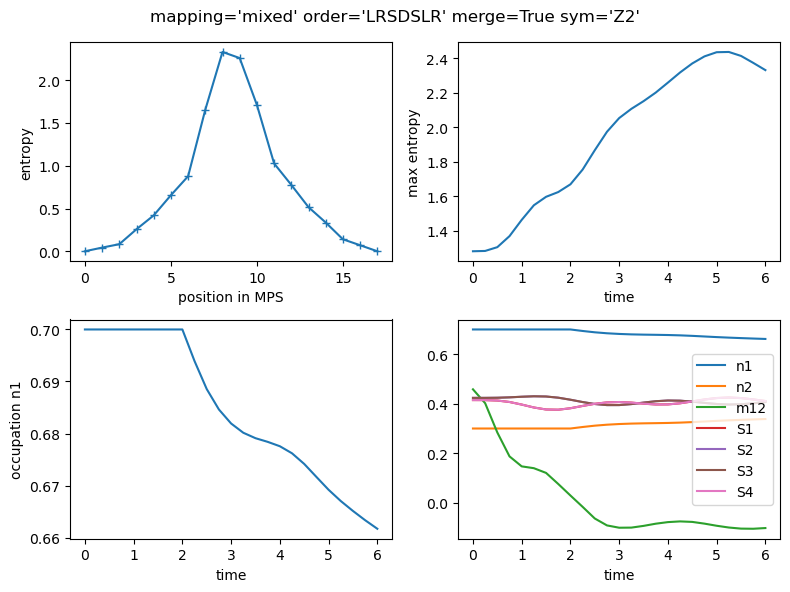

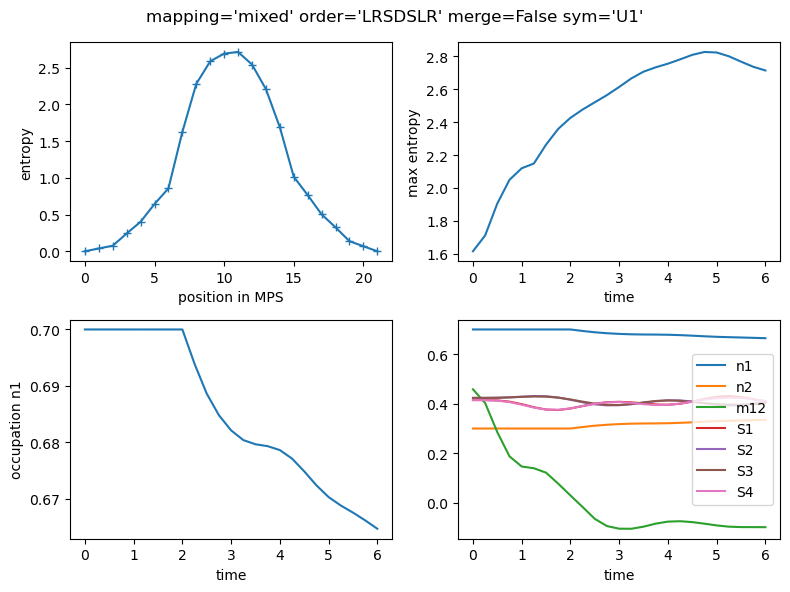

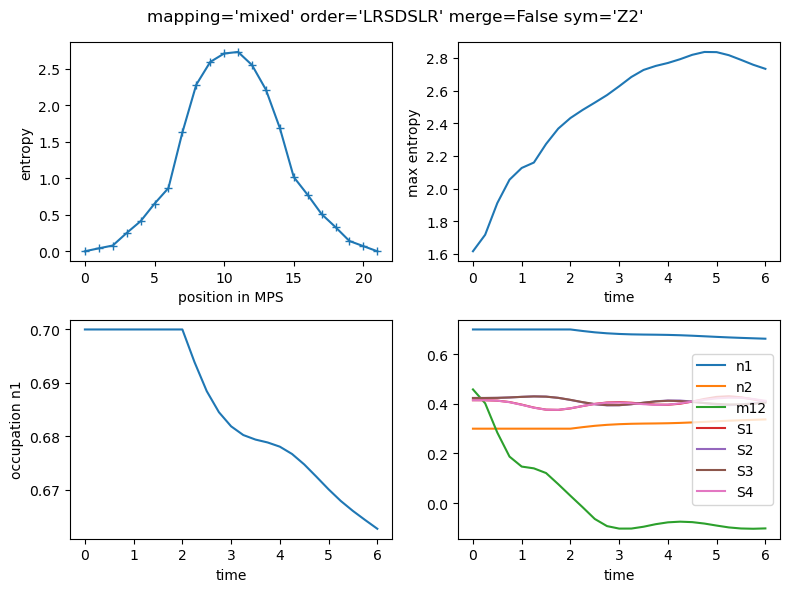

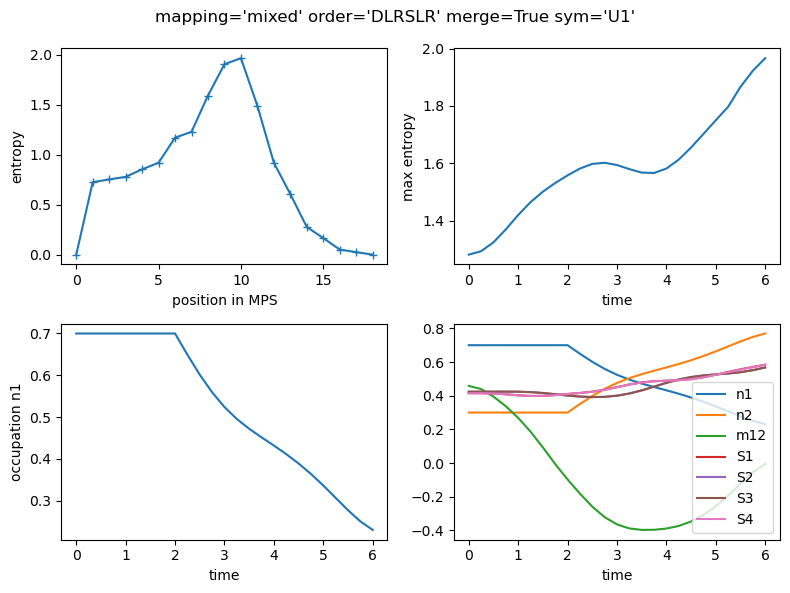

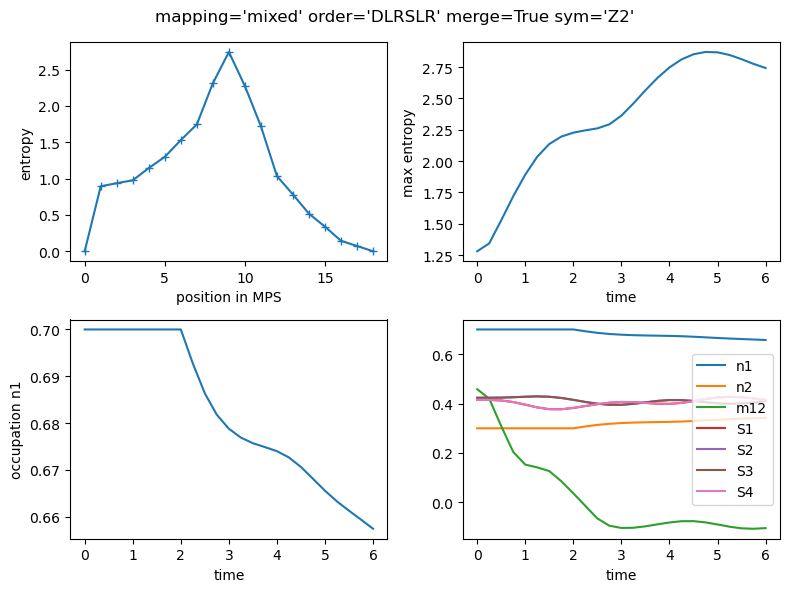

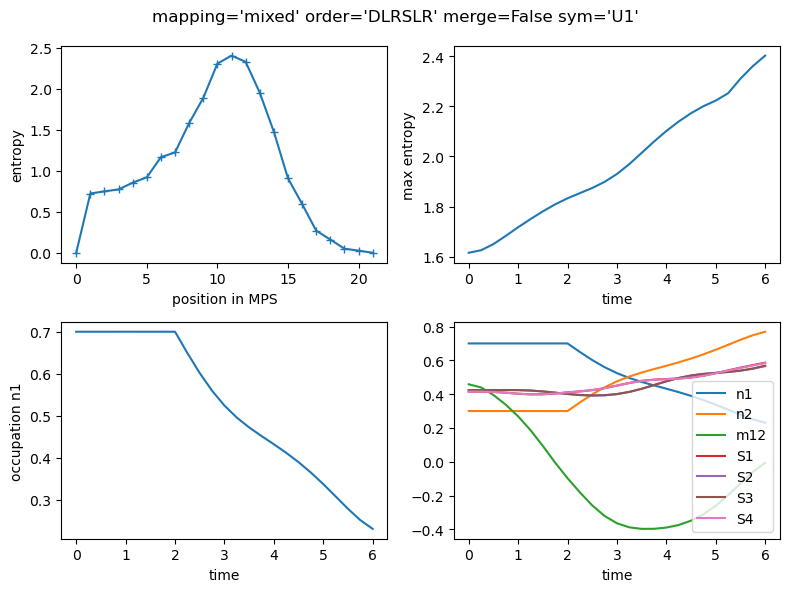

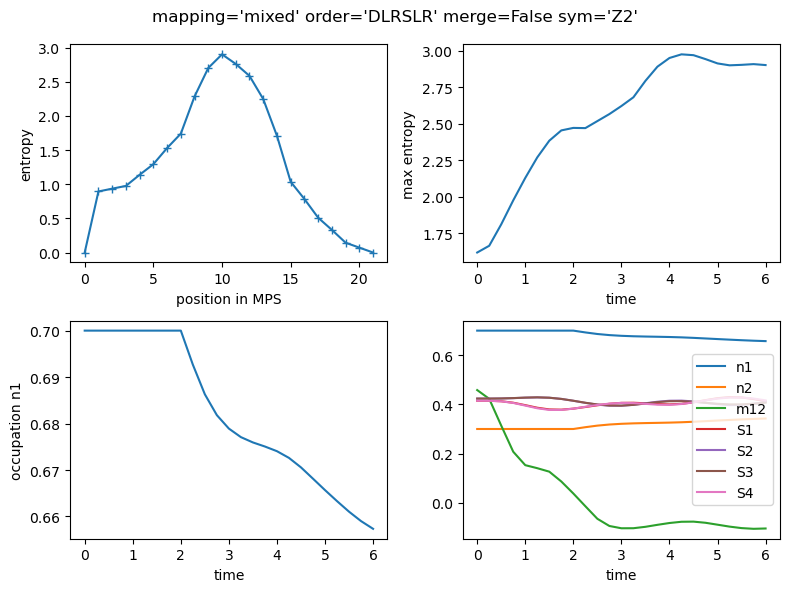

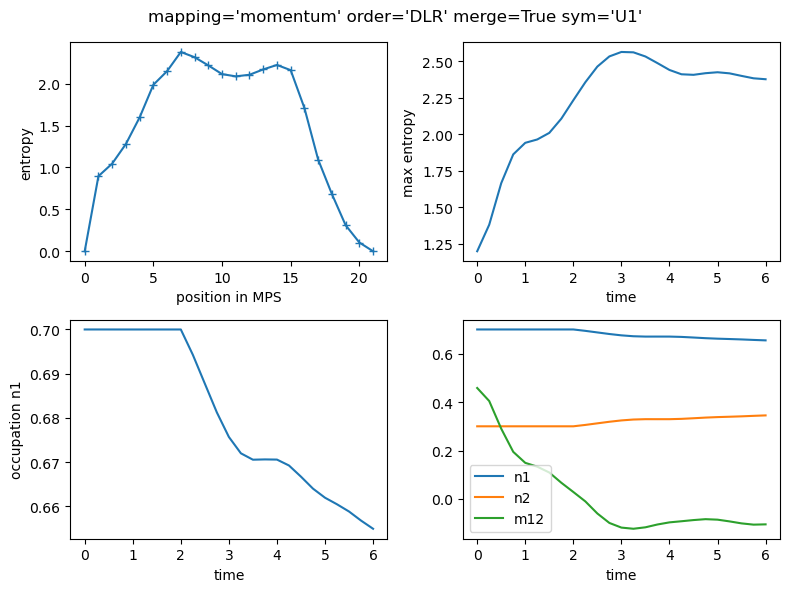

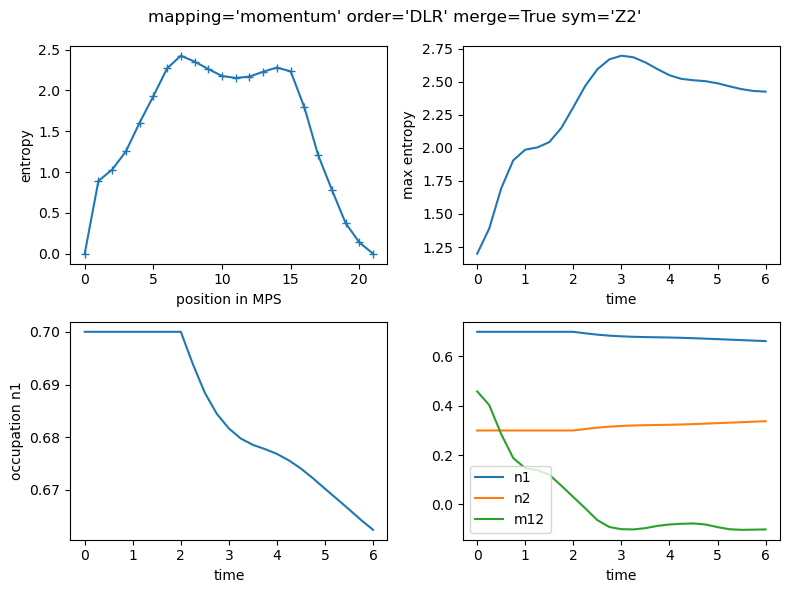

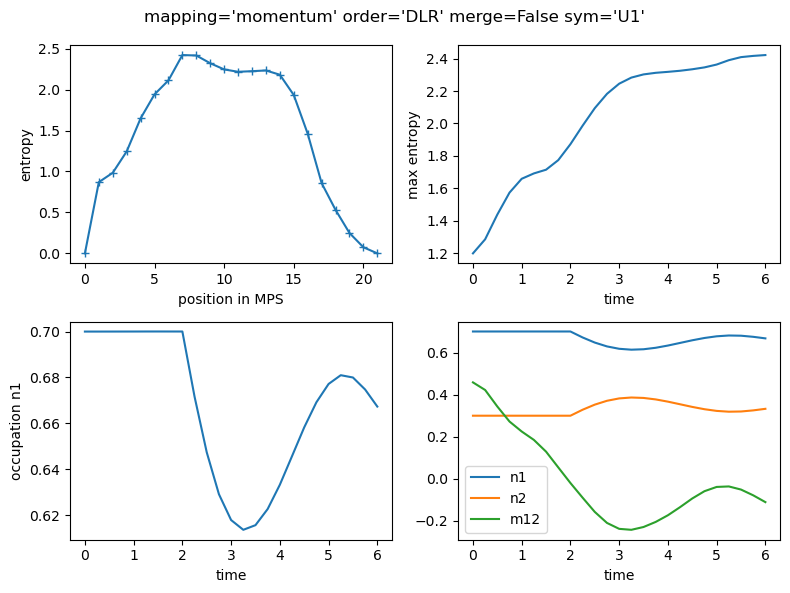

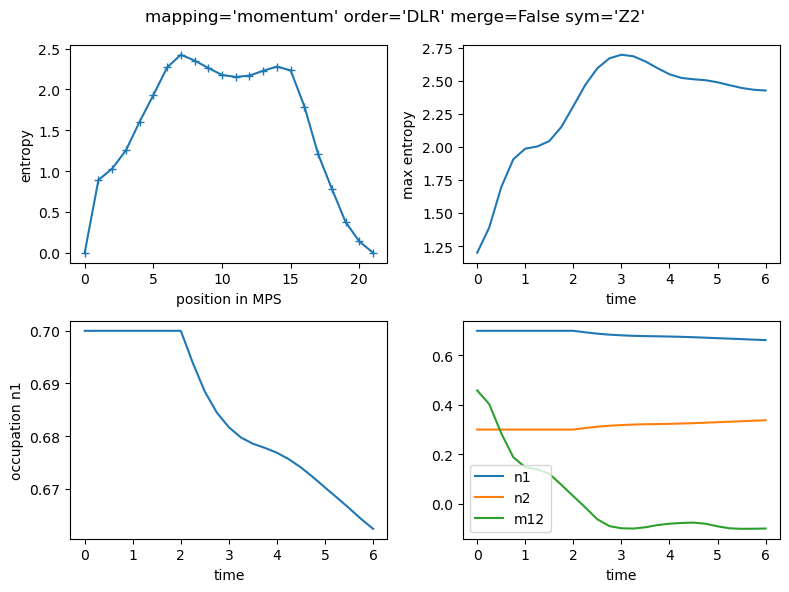

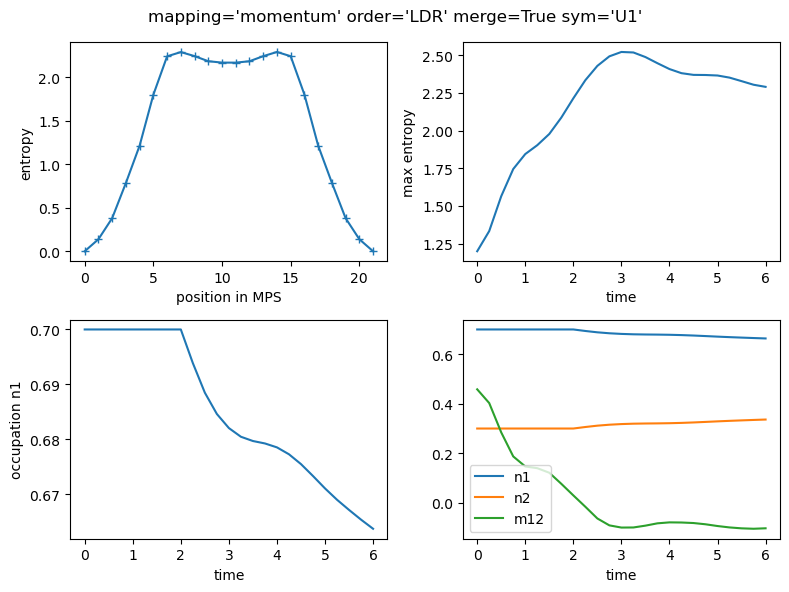

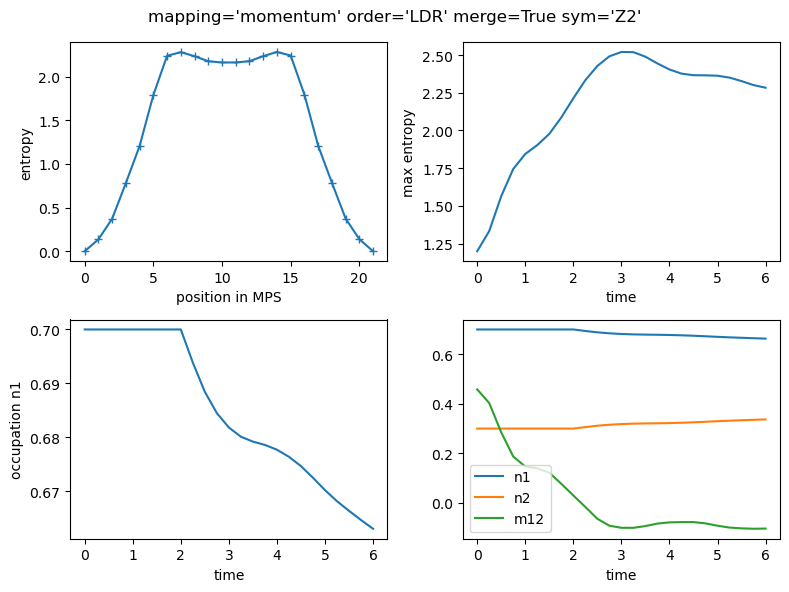

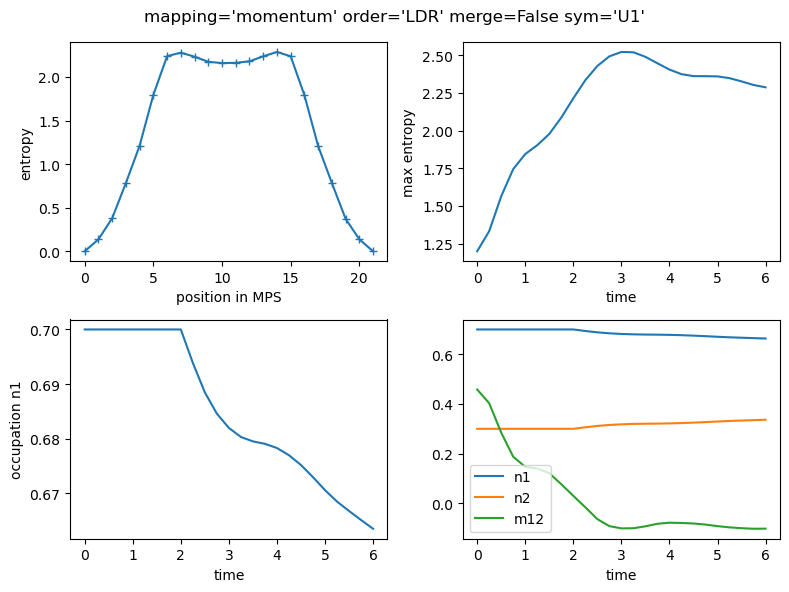

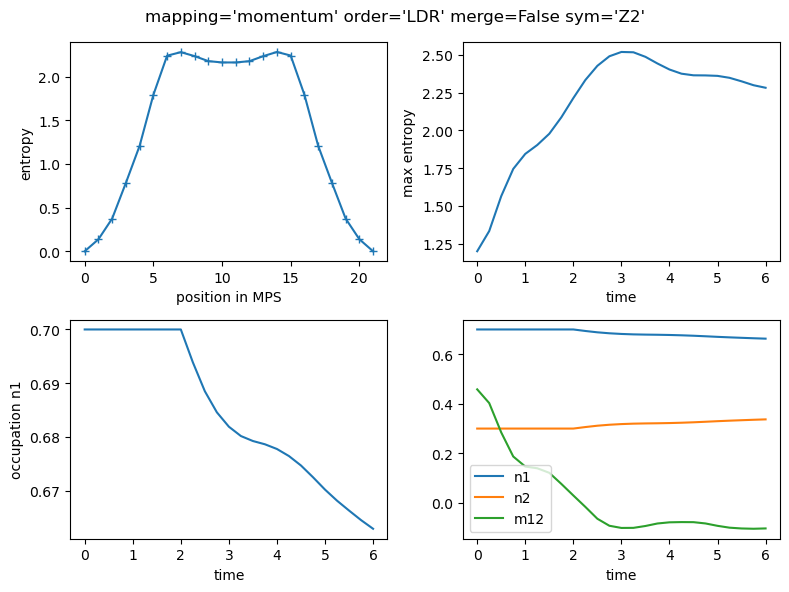

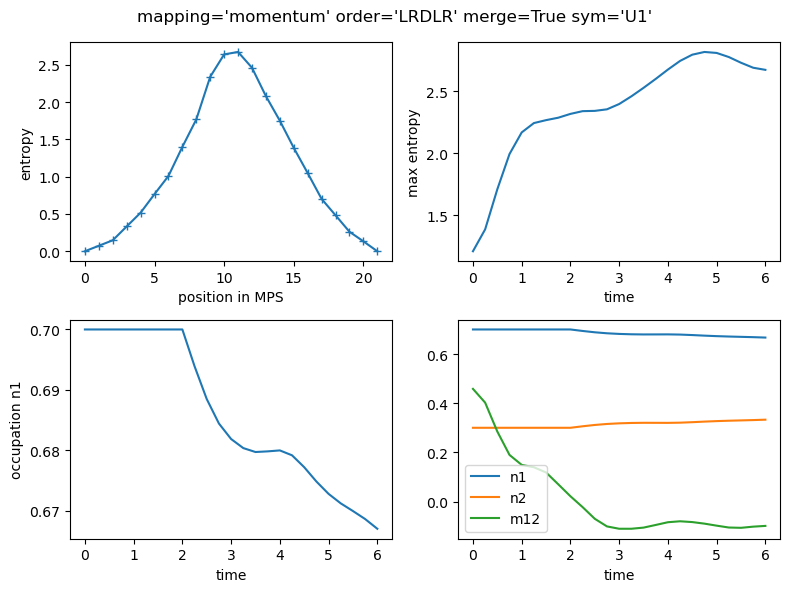

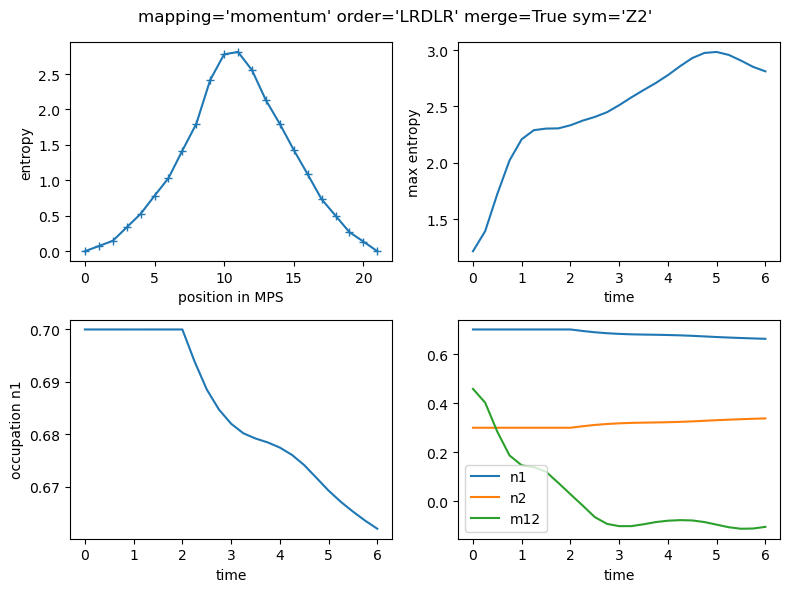

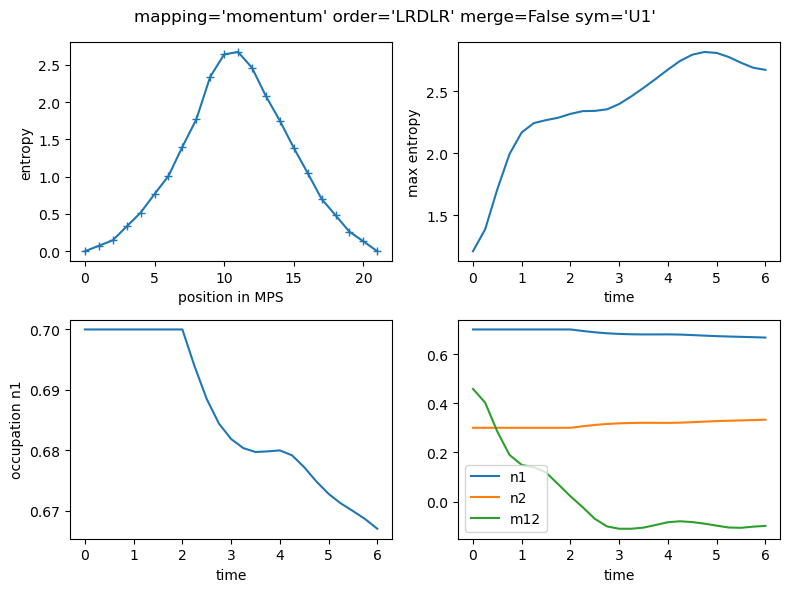

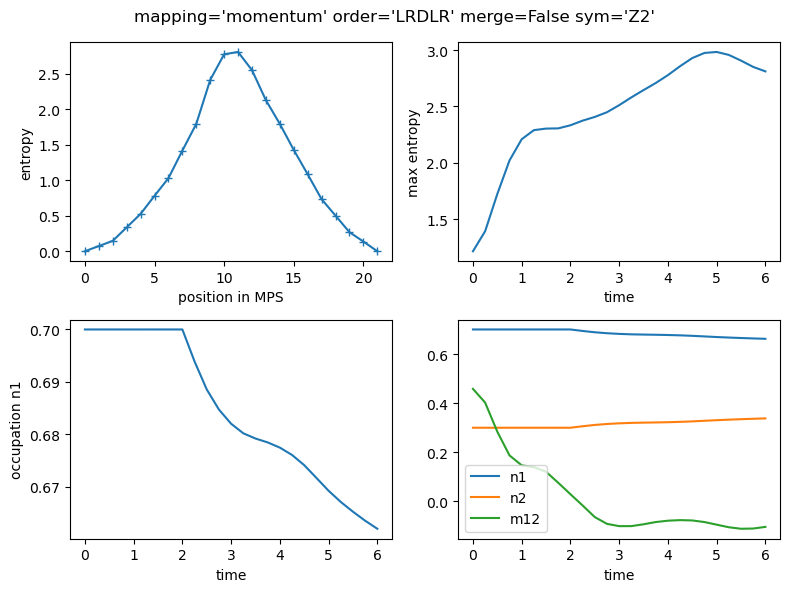

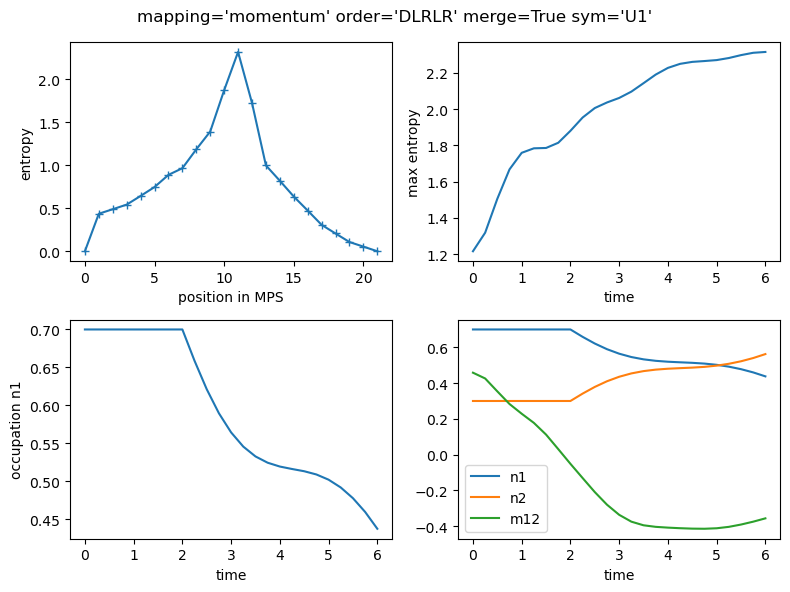

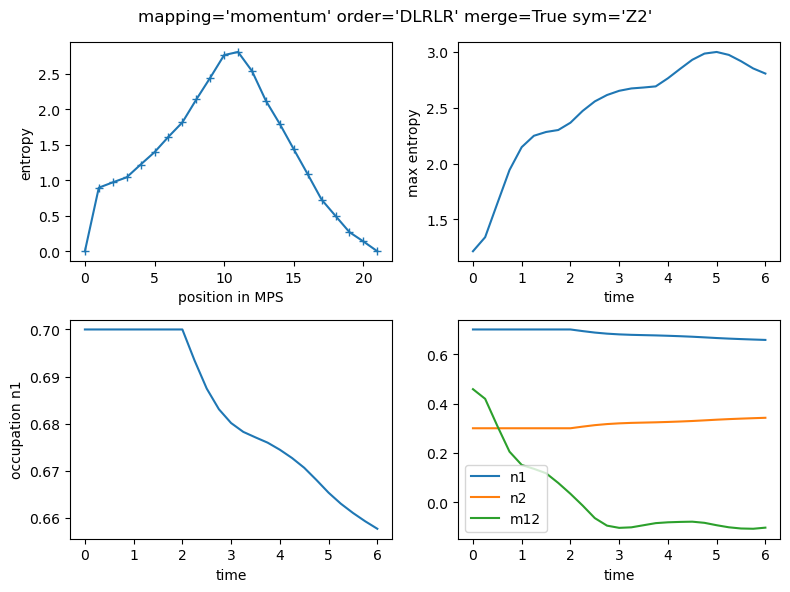

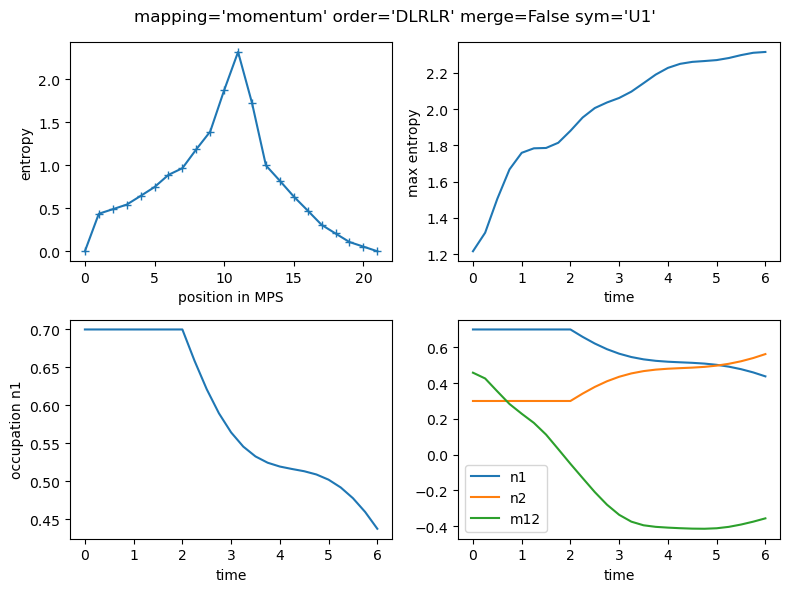

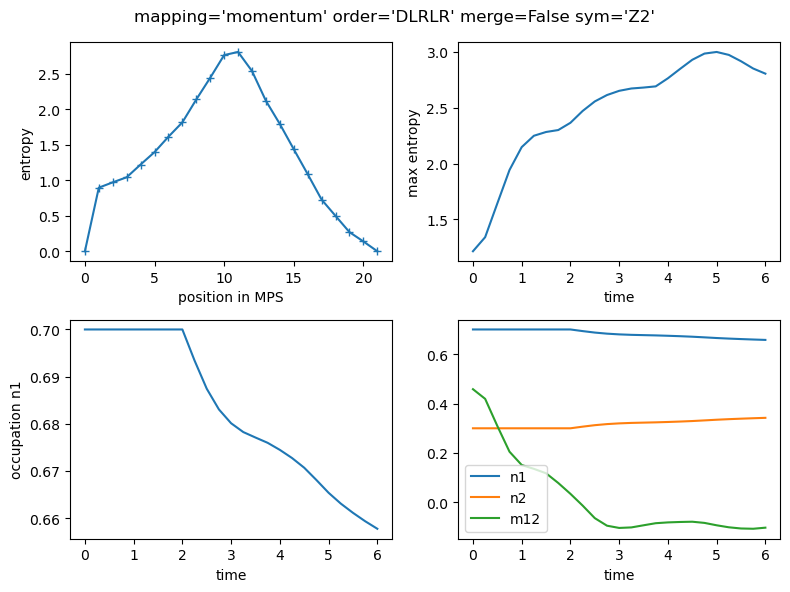

In [36]:
for k, v in out.items():
    plot_data(*v, *k)